#### 1. Import libraries.

In [1]:
%cd ..

# Start of solving conflict between TensorFlow & Pandas
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

import tensorflow as tf
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
# End of solving conflict between TensorFlow & Pandas :-)

import chess
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from tqdm import tqdm

from src.chess_ai.core.model import ChessAI
from src.utils.tools import test_puzzle_detailed


/Users/mateuszgrzyb/projekty/searchless_chess


#### 2. Load data.

In [2]:
puzzles = pd.read_feather('data/puzzles/test_puzzles.feather')
puzzles['moves'] = puzzles['moves'].str.split(' ')

#### 3. Load model.

In [3]:
# Loading ResNet CNN L-size model. Estimated elo ~1700.
chess_bot = ChessAI('checkpoints/model_03_resnet_l/best_model.keras')

#### 4. Solving puzzles.

In [4]:
detailed_results = []
for i, row in enumerate(tqdm(puzzles.itertuples(index=True), total=puzzles.shape[0])):
    result = test_puzzle_detailed(row, chess_bot)
    detailed_results.append(result)

100%|██████████| 1200/1200 [21:10<00:00,  1.06s/it]


#### 5. Summary.

##### 5.1. General summary.

In [5]:
full_success = sum(1 for r in detailed_results if r['success'])
partial_success = sum(1 for r in detailed_results if r['correct_moves'] > 0 and not r['success'])

print(f"Fully solved puzzles: {round(full_success/len(detailed_results), 2)*100}%")
print(f"Partially solved puzzles: {round(partial_success/len(detailed_results), 2)*100}%")
print(f"Completely unsolved puzzles: {round((len(detailed_results) - full_success - partial_success)/len(detailed_results), 2)*100}%")

Fully solved puzzles: 49.0%
Partially solved puzzles: 20.0%
Completely unsolved puzzles: 31.0%


##### 5.2. Percentage of solved puzzles on every level.

In [6]:
results = [res['success'] for res in detailed_results]
puzzles['res'] = results
puzzles['rating_cut'] = pd.cut(puzzles.rating, [0, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250])
grouped = puzzles.groupby('rating_cut', observed=True).res.agg(['mean', 'count'])
grouped

,mean,count
rating_cut,,
"(0, 500]",0.95,100
"(500, 750]",0.91,100
"(750, 1000]",0.88,100
"(1000, 1250]",0.76,100
"(1250, 1500]",0.79,100
"(1500, 1750]",0.59,100
"(1750, 2000]",0.48,100
"(2000, 2250]",0.23,100
"(2250, 2500]",0.14,100


##### 5.3. Estimating Elo using linear regression.

Estimated ELO: 1711.83


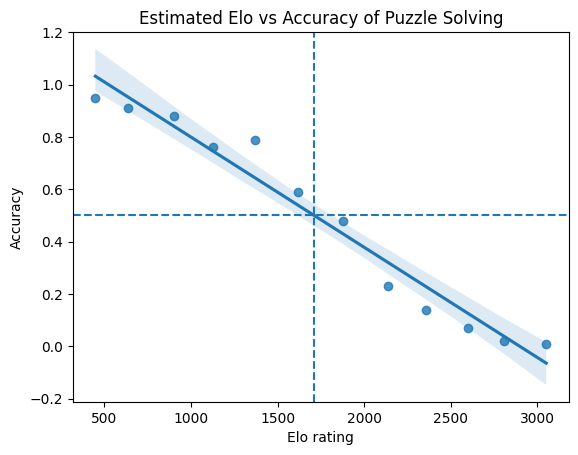

In [7]:
y = puzzles.groupby('rating_cut', observed=True).rating.mean().values
X = grouped['mean'].values.reshape(-1, 1)
lr = LinearRegression()
lr.fit(X, y)
estimated_elo = lr.predict([[0.5]])[0]
print('Estimated ELO:', round(estimated_elo, 2))

sns.regplot(
    x=puzzles.groupby('rating_cut', observed=True).rating.mean(),
    y=grouped['mean'].values
)

plt.axhline(0.5, linestyle='--')
plt.axvline(estimated_elo, linestyle='--')
plt.ylabel("Accuracy")
plt.xlabel("Elo rating")
plt.title("Estimated Elo vs Accuracy of Puzzle Solving")

plt.show()